In [1]:
import torch
import requests
from pathlib import Path
import hashlib
import re
import sys
import tarfile
import pandas as pd
pd.options.display.max_colwidth = 100
pd.set_option('display.max_colwidth', None)

In [2]:
!pip install --upgrade transformers

     |████████████████████████████████| 4.4 MB 4.4 MB/s eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.19.4
    Uninstalling transformers-4.19.4:
      Successfully uninstalled transformers-4.19.4


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# Download the dataset
import requests

fname = 'wikitext-103.tar.gz'
url = 'https://dax-cdn.cdn.appdomain.cloud/dax-wikitext-103/1.0.1/' + fname
r = requests.get(url)
Path(fname).write_bytes(r.content)

189603606

In [5]:
# Verify the file was downloaded properly by comparing sha512 checksums
sha512sum = 'c8186919aa1840af6b734ea41abc580574ea8efe2fafda220f5d01002464d17566d84be5199b875136c9593f0e0678fb5d7c84bb2231de8b4151cb9c83fa2109'
sha512sum_computed = hashlib.sha512(Path('wikitext-103.tar.gz').read_bytes()).hexdigest()
sha512sum == sha512sum_computed

True

In [6]:
# Extract the dataset
with tarfile.open(fname) as tar:
    tar.extractall()

In [7]:
test_data = Path('wikitext-103/wiki.test.tokens').read_text()

In [8]:
# Store regular expression pattern to search for wikipedia article headings
heading_pattern = '( \n \n = [^=]*[^=] = \n \n )'

In [9]:
# Split out test headings and articles
test_split = re.split(heading_pattern, test_data)
test_headings = [x[7:-7] for x in test_split[1::2]]
test_articles = [x for x in test_split[2::2]]

In [10]:
# Do we need tokens . and , and '? for now retain as span bert may rely on them for predictions
# remove any unkowns in the sentence as well
clean_articles = []
for idx in range(len(test_articles)):
    clean_text = re.sub('[^ a-zA-Z0-9.\',?]|unk', '', test_articles[idx])
    clean_text = re.sub(' +', ' ', clean_text)
    clean_articles.append(clean_text)




In [24]:
unique_words = set()
for a in clean_articles:
    unique_words = unique_words.union(set(a.split(" ")))
print(len(unique_words))

19606


In [11]:
# lemmatize the entire dataset
from nltk.tokenize import sent_tokenize
sentences_ds = []
for idx in range(len(clean_articles)):
    sentences_ds.extend(sent_tokenize(clean_articles[idx]))

/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

In [12]:
max_seq_len = 512

def get_end_id(lemmatized_sentences_list, start_id):
    num_words = 0
    
    for ind in range(start_id, len(sentences_ds)):
        num_words += len(sentences_ds[ind].split(" "))
        #print("Num words: {}".format(num_words))
        #print("Sent len: {}".format(len(sentences_ds[ind].split(" "))))
        if num_words > max_seq_len:
            return ind

In [13]:
# for the VAD values read from NRC-VAD-Lexicon.txt
columns = ["word", "valence", "arousal", "dominance"]
vad_df = pd.DataFrame(columns=columns)

import csv

word_list = []
valence = []
arousal = []
dominance = []

with open("NRC-VAD-Lexicon.txt") as tsv:
    for line in csv.reader(tsv, delimiter='\t'):
        word_list.append(line[0])
        valence.append(line[1])
        arousal.append(line[2])
        dominance.append(line[3])

vad_df["word"] = word_list
vad_df["valence"] = valence
vad_df["arousal"] = arousal
vad_df["dominance"] = dominance

In [14]:
def lemmatize_query(query_word):
    lemmatized_query = lemmatizer.lemmatize(query_word)
    return lemmatized_query

In [15]:
def lemmatize_context(context):
    lemmatized_output = []
    for w in context:
        lemmatized_output.append(lemmatizer.lemmatize(w))
    return lemmatized_output

In [16]:
def get_label(query, context):
    # evaluate verbatim recall for now so do not lemmatize or consider synonyms
    #lemmatized_query = lemmatize_query(query)
    # nltk sentence tokenizer doesnt split words properly - e.g. is split as e.g and . and then lemmatized
    # but lemmatization of e.g. is e.g. so you will not find lemmatized query in word_dict 
    # in such cases just take the query word as is 
    """
    if lemmatized_query in word_dict:
        expanaded_query = word_dict[lemmatized_query]
    else:
        expanaded_query = lemmatized_query
    """
    # lemmatize the context 
    #lemmatized_context = lemmatize_context(context)
    """
    if (set(expanaded_query) & set(lemmatized_context)):
        label = 1
    else:
        label = 0
    """
    if query in context:
        label = 1
    else:
        label = 0
    #print(f'context: {" ".join(context)}, query: {query}, label: {label}, length {len(context)}')
    return label  

In [17]:
from tqdm import tqdm

In [18]:
spl_char = ['.', '\'', '?', ',']

data = []

for sent_id in tqdm(range(len(sentences_ds))):
    end_id = get_end_id(sentences_ds, sent_id)
    chunk_clean = " ".join(sentences_ds[sent_id:end_id]).split(" ") 

    for idx, query in enumerate(chunk_clean[1:]):
        if query not in spl_char and not query.isnumeric():
            context = chunk_clean[:idx+1]
            label = get_label(query, context)
            data.append({"query": query, "context": " ".join(context), "label": label, "context_length": len(context)})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9468/9468 [00:35<00:00, 269.21it/s]


In [91]:
df = pd.DataFrame(data)

In [92]:
# number of unique queries in the unbalanced dataset
len(df['query'].unique())

18856

In [93]:
df = df[df['context_length'] < 400]

In [94]:
df[df['context_length'] > 400]

,query,context,label,context_length


In [95]:
# number of unique queries in the unbalanced dataset
len(df['query'].unique())

18856

In [96]:
df_pos_full = df[df['label'] == 1]
df_neg_full = df[df['label'] == 0]

In [97]:
len(df_pos_full['query'].unique())

6122

In [175]:
# ignore samples greater than 400 as context length, this is so that word piece tokenization and lstm tokenization
# which expand the number of tokens still fit into 512.
#df_pos = df_pos_full[df_pos_full['context_length'] < 400]
#df_neg = df_neg_full[df_neg_full['context_length'] < 400]

In [98]:
# keep a tab of query and number of times it is positive
pos_query_count = df_pos_full.groupby('query').apply(lambda x: len(x)).to_dict()

In [99]:
max_N = 10

In [100]:
for key, value in pos_query_count.items():
    if pos_query_count[key] > max_N:
        pos_query_count[key] = max_N

In [101]:
sampled_df_neg = df_neg_full.groupby('query', group_keys=False).apply(
    lambda x: x.sample(n=min(pos_query_count[x.iloc[0]["query"]], len(x))
                       if (x.iloc[0]["query"] in pos_query_count) else 1)
)

In [102]:
len(sampled_df_neg)

70275

In [103]:
#query_neg = (sampled_df_neg.groupby('query').size() - df_pos.groupby('query').size()).dropna().index.to_list()
query_neg = (sampled_df_neg['query'].unique())

In [104]:
len(query_neg)

18856

In [105]:
sampled_df_pos = df_pos_full.groupby('query', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), max_N))
)

In [106]:
len(sampled_df_pos)

57543

In [107]:
sampled_df = pd.concat([sampled_df_pos, sampled_df_neg])

In [108]:
# this will have both positive and negative samples of the same query grouped together, so easier to split into train
# and test with non overlapping samples
#sampled_df_grouped = sampled_df.sort_values(by='query')

In [109]:
# create a train, test, and validation split
from sklearn.model_selection import train_test_split

train_val_query, test_query = train_test_split(sampled_df["query"].unique().tolist(), test_size=0.3, random_state=2, shuffle=True)

In [110]:
train_query, val_query = train_test_split(train_val_query, test_size=0.2, random_state=2, shuffle=True)

In [111]:
print(f" train_query len: {len(train_query)}, val_query len: {len(val_query)}, test_query len: {len(test_query)}")

 train_query len: 10559, val_query len: 2640, test_query len: 5657


In [112]:
train_df = sampled_df[sampled_df["query"].isin(train_query)]
val_df = sampled_df[sampled_df["query"].isin(val_query)]
test_df = sampled_df[sampled_df["query"].isin(test_query)]

In [113]:
print(len(train_df), len(train_df["query"].unique()))
print(len(val_df), len(val_df["query"].unique()))
print(len(test_df), len(test_df["query"].unique()))

70928 10559
18272 2640
38618 5657


<AxesSubplot:>

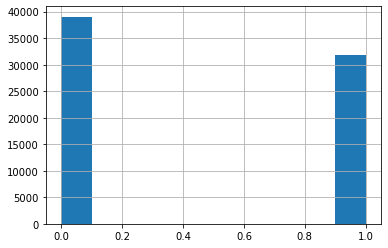

In [114]:
train_df["label"].hist()

<AxesSubplot:>

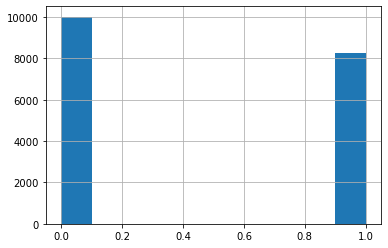

In [115]:
val_df["label"].hist()

<AxesSubplot:>

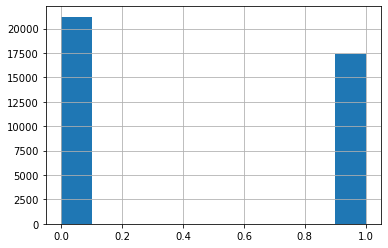

In [116]:
test_df["label"].hist()

In [208]:
# store all the dataframes in csv format, unpickling can be an issue if you mess with the pandas version numbers
#train_df.to_csv("18k_query_lm_recall_train.csv", sep="\t", index=False)
#val_df.to_csv("balanced_lm_recall_val.csv", sep="\t", index=False)
#test_df.to_csv("balanced_lm_recall_test.csv", sep="\t", index=False)

In [117]:
train_df.to_json("18k_query_lm_recall_train.json")
val_df.to_json("18k_query_lm_recall_val.json")
test_df.to_json("18k_query_lm_recall_test.json")